In [247]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *          

In [248]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Model Bias and Variance

In this section, we provide a different way to think about the problem of over- and under-fitting. We carry out a simulation study where we generate synthetic data from a model of our design. This way, we know the true model, and we can see how close we get to the truth when we fit models to the data. 

We concoct a general model of data as follows:

$$ y = g(\mathbf{x}) + {\epsilon}.$$

This expression makes it easy to see the two components of the model, the signal, $g(x)$ and the noise $ \epsilon $. In our model, we assume that the the noise has no trend or pattern, constant variance, and each observation's noise is independent of the others'. 

As an example, let's take $ g(x) = \sin(x) + 0.3x $ and the noise from a normal curve with center 0 and SD = 0.2.  We can generate data from this model with the following functions:

In [249]:
def g(x):
    return np.sin(x) + 0.3 * x

def gen_noise(n):
    return np.random.normal(scale=0.2, size=n)

def draw(n):
    points = np.random.choice(np.arange(0, 10, 0.05), size=n)
    return points, g(points) + gen_noise(n)

Let's generate 50 data points $ (x_i, y_i)$, $i=1, \ldots, 50 $, from this model:

In [250]:
np.random.seed(42)

xs, ys = draw(50)
noise = ys - g(xs)

We can plot our data, and since we know the true signal, we can find the errors and plot them too:

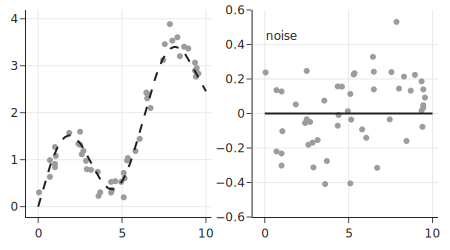

In [251]:
x_full = np.linspace(0, 10, num=100)
y_true = g(x_full)
pewter = "rgba(153, 157, 160, 1)"
charcoal = "rgba(34, 32, 33, 1)"

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=xs, y=ys, mode="markers", line_color=pewter), row=1, col=1
)

fig.add_trace(
    go.Scatter(x=x_full, y=y_true, line_dash="dash", line_color=charcoal),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(x=xs, y=noise, mode="markers", line_color=pewter), row=1, col=2
)

fig.add_trace(
    go.Scatter(x=[0, 10], y=[0, 0], mode="lines", line_color=charcoal),
    row=1,
    col=2,
)

fig.add_annotation(x=1, y=0.45, text="noise", showarrow=False, row=1, col=2)

fig.update_yaxes(range=[-0.6, 0.6], row=1, col=2)
fig.update_layout(height=250, width=450, showlegend=False)
fig.show()

The plot on the left shows $g$ as a dashed curve. We can also see the $ (x, y) $ pairs form a scatter of dots about this curve. The right hand plot shows the errors, $ y - g(x) $, for the 50 points. Notice that they do not form a pattern.  

When we fit a model to the data, we minimize the mean square error. Let's write this minimization in  generality, 

$$
\min_{f \in \cal{F}} \frac{1}{n} \sum_{i = 1}^{n} [y_i - f(\mathbf{x}_i)]^2 
$$

The minimization is over the collection of functions $ \cal{F} $. We have seen in this chapter that this collection of functions might be polynomials of 12 degrees, or simply bent lines. An important point is that the true model, $g$, doesn't have to be one of the functions in the collection.

Let's take $ \cal{F} $ to be the collection of second degree polynomials; in other words, functions that can be expressed as $ \theta_0 + \theta_1 x + \theta_2 x^2$. Since $ g(x) = \sin(x) + 0.3x $, it doesn't belong to the collection of functions that we are optimizing over.

Let's fit a polynomial to our 50 data points,

In [252]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(xs.reshape(-1, 1))

model_deg2 = LinearRegression().fit(poly_features, ys)

In [254]:
print(f"Fitted Model: {model_deg2.intercept_:.2f}",
      f"+ {model_deg2.coef_[0]:.2f}x + {model_deg2.coef_[1]:.2f}x^2")

Fitted Model: 0.98 + -0.19x + 0.05x^2


Again, we know the true model is not quadratic (because we built it). Let's plot the data and the fitted curve:

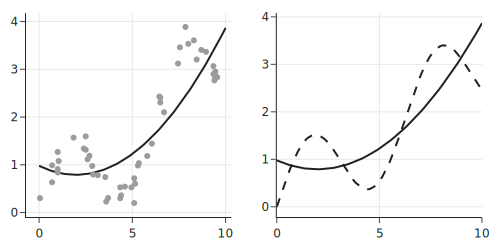

In [255]:
poly_features_x_full = poly.fit_transform(x_full.reshape(-1, 1))
ys_fit_full = model_deg2.predict(poly_features_x_full).flatten()

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=x_full, y=ys_fit_full, line_color=charcoal), row=1, col=1
)

fig.add_trace(
    go.Scatter(x=xs, y=ys, mode="markers", line_color=pewter), row=1, col=1
)

fig.add_trace(
    go.Scatter(x=x_full, y=ys_fit_full, line_color=charcoal), row=1, col=2
)

fig.add_trace(
    go.Scatter(x=x_full, y=y_true, line_dash="dash", line_color=charcoal),
    row=1,
    col=2,
)


fig.update_layout(height=250, width=500, showlegend=False)
fig.show()

The quadratic doesn't fit the data well, and it doesn't represent the underlying curve well either because the set of models that we are choosing from (second order polynomials) can't capture the curvature in $ g $. 

If we repeat this process, and generate another 50 points from the true  model and fit a second degree polynomial to these data, then the fitted coefficients of the quadratic will change because it depends on the new set of data. We can repeat this process many times, and average the fitted curves. This average curve will resemble the typical best fit of a second degree polynomial to 50 points from our true model. To demonstrate this notion, let's generate 25 sets of 50 data points and fit a quadratic to each dataset:

In [256]:
def fit(n):
    xs_new = np.random.choice(np.arange(0, 10, 0.05), size=n)
    ys_new = g(xs_new) + gen_noise(n)
    X_new = xs_new.reshape(-1, 1)
    mod_new = LinearRegression().fit(poly.fit_transform(X_new), ys_new)
    return mod_new.predict(poly_features_x_full).flatten()

In [257]:
fits = [fit(50) for j in range(25)]

We can show on a plot all 25 fitted models along with the true function, $g$, and the average of the fitted curves $ \bar{f} $. To do this, we use transparency for the 25 fitted models to distinguish overlapping curves:

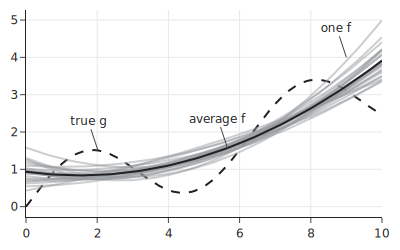

In [258]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=x_full, y=y_true, line_color=charcoal, line_dash="dash")
)

for j in range(25):
    fig.add_trace(
        go.Scatter(x=x_full, y=fits[j], line_color="rgba(153, 157, 160, 0.5)")
    )

fig.add_trace(
    go.Scatter(x=x_full, y=np.mean(fits, axis=0), line_color=charcoal)
)


fig.add_annotation(x=2.02, y=1.51, text="true g")

fig.add_annotation(x=9, y=4.0, text="one f")

fig.add_annotation(x=5.66, y=1.57, text="average f")

fig.update_layout(height=250, width=400, showlegend=False)
fig.show()

We can see the 25 fitted quadratics vary with the data. This concept is called *model variation*. The average of the 25 quadratics is represented by the solid black line. The difference between the average quadratic and the true curve is called the *model bias*. 

When the signal, $ g $,  does not belong to the model space, $ \cal{F} $, we have model bias. If the model space can approximate $g$ well, then the bias is small. For instance, a 10-degree polynomial can get pretty close to the $g$ used in our example.  On the other hand, we have seen earlier in this chapter that higher degree polynomials can over-fit the data and vary a lot trying to get close to the data. The more complex the model space, the greater the variability in the fitted model.  Under-fitting with too simple of a model can lead to high model bias (the difference between $g$ and $\bar{f}$), and over-fitting with too complex of a model can result in high model variance (the fluctuations of $\hat{f}$ around $\bar{f}$). This notion is called the *bias-variance trade off*. Model selection aims to balance these competing sources of a lack of fit.